Data Source: Fintraffic / digitraffic.fi, license CC 4.0 BY

In [1]:
from utils.fetch import fetch_train_for_dates
from utils.transform import train_list_to_dataframe
import datetime
import zoneinfo
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="darkgrid")

In [2]:
def plot_differences(
    df: pl.DataFrame, width: float = 10.0, height: float = 10.0
) -> None:
    fig, axs = plt.subplots(nrows=3, ncols=1)
    plt.tight_layout()

    fig.set_figwidth(val=width)
    fig.set_figheight(val=height)

    df = pl.concat(
        [
            df.select(
                pl.col("train_number"),
                pl.col("departure_date"),
                pl.col("cancelled"),
                pl.col("train_type"),
                pl.lit("DEPARTURE").alias("type"),
                pl.col("departure_actual_difference").alias("delay"),
            ),
            df.select(
                pl.col("train_number"),
                pl.col("departure_date"),
                pl.col("cancelled"),
                pl.col("train_type"),
                pl.lit("ARRIVAL").alias("type"),
                pl.col("arrival_actual_difference").alias("delay"),
            ),
        ]
    )

    sns.lineplot(data=df, x="departure_date", y="delay", hue="type", ax=axs[0])
    axs[0].set_xlabel("Date")
    axs[0].set_ylabel("Schedule delay (min)")
    axs[0].set_ylim([0.0, 30.0])

    sns.histplot(
        data=df.filter(pl.col("type") == "DEPARTURE"),
        x="delay",
        binwidth=1.0,
        ax=axs[1],
    )
    axs[1].set_title("Departure delays (min)")

    sns.histplot(
        data=df.filter(pl.col("type") == "ARRIVAL"), x="delay", binwidth=1.0, ax=axs[2]
    )
    axs[2].set_title("Arrival delays (min)")

In [3]:
def print_summary(df: pl.DataFrame) -> None:
    dep_datetime: datetime.datetime = (
        df.sort(by=pl.col("departure_date"), descending=True)
        .limit(1)
        .to_dicts()[0]["departure_scheduled_time"]
    )
    dep_time = dep_datetime.astimezone(
        tz=zoneinfo.ZoneInfo(key="Europe/Helsinki")
    ).time()
    print(
        "Scheduled departure time:",
        dep_time,
    )

    arr_datetime: datetime.datetime = (
        df.sort(by=pl.col("departure_date"), descending=True)
        .limit(1)
        .to_dicts()[0]["arrival_scheduled_time"]
    )
    arr_time = arr_datetime.astimezone(
        tz=zoneinfo.ZoneInfo(key="Europe/Helsinki")
    ).time()
    print(
        "Scheduled arrival time:",
        arr_time,
    )

    print("Delay stats:")
    print(
        df.select(pl.col("arrival_actual_difference").alias("Delay (min)"))
        .describe(percentiles=[0.5, 0.9, 0.95])
        .filter(pl.col("statistic").is_in(["min", "max", "50%", "90%", "95%"]))
        .with_columns(
            (
                pl.lit(
                    arr_datetime.astimezone(tz=zoneinfo.ZoneInfo(key="Europe/Helsinki"))
                )
                + pl.duration(seconds=60 * pl.col("Delay (min)"))
            )
            .dt.time()
            .alias("Arrival time")
        )
    )

In [4]:
today = datetime.date.today()
date_list = [today - datetime.timedelta(days=diff) for diff in range(120)]
date_list = [d for d in date_list if d.weekday() < 5]

# Tampere -> Pasila

In [5]:
train_list_166 = await fetch_train_for_dates(
    train=166,
    dates=date_list,
    max_concurrent=5,
    sleep_after_sec=1.0,
)
df_166 = train_list_to_dataframe(
    train_list=train_list_166, departure="TPE", arrival="PSL"
)

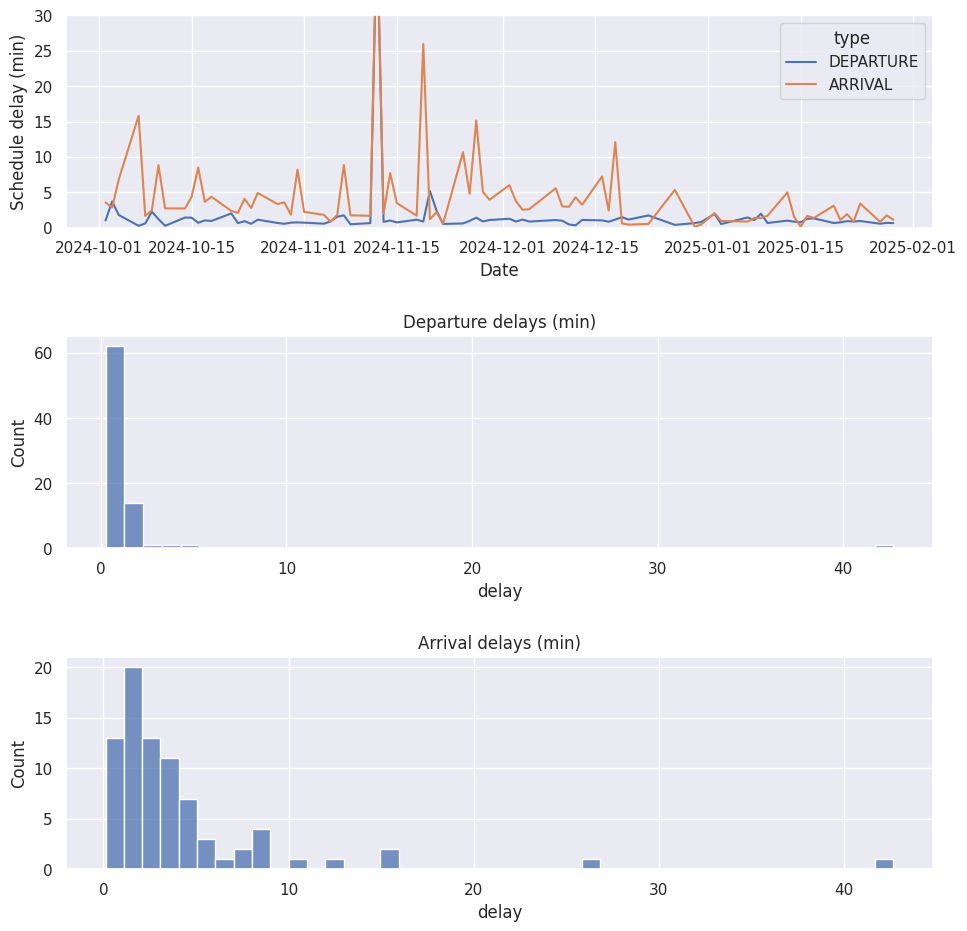

In [6]:
plot_differences(df=df_166)

In [7]:
print_summary(df=df_166)

Scheduled departure time: 06:22:00
Scheduled arrival time: 08:03:00
Delay stats:
shape: (5, 3)
┌───────────┬─────────────┬──────────────┐
│ statistic ┆ Delay (min) ┆ Arrival time │
│ ---       ┆ ---         ┆ ---          │
│ str       ┆ f64         ┆ time         │
╞═══════════╪═════════════╪══════════════╡
│ min       ┆ 0.116667    ┆ 08:03:07     │
│ 50%       ┆ 2.7         ┆ 08:05:42     │
│ 90%       ┆ 8.483333    ┆ 08:11:28     │
│ 95%       ┆ 12.1        ┆ 08:15:06     │
│ max       ┆ 42.666667   ┆ 08:45:40     │
└───────────┴─────────────┴──────────────┘


In [8]:
train_list_40 = await fetch_train_for_dates(
    train=40,
    dates=date_list,
    max_concurrent=5,
    sleep_after_sec=1.0,
)
df_40 = train_list_to_dataframe(
    train_list=train_list_40, departure="TPE", arrival="PSL"
)

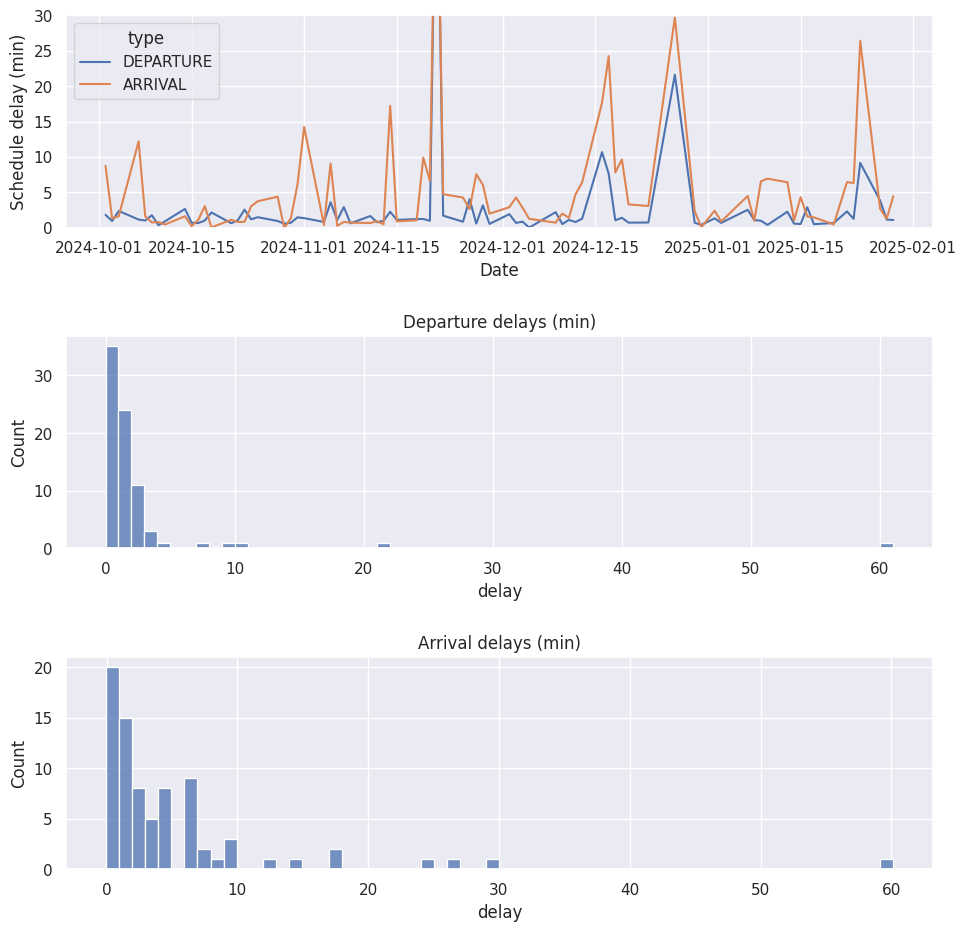

In [9]:
plot_differences(df=df_40)

In [10]:
print_summary(df=df_40)

Scheduled departure time: 07:00:00
Scheduled arrival time: 08:28:00
Delay stats:
shape: (5, 3)
┌───────────┬─────────────┬──────────────┐
│ statistic ┆ Delay (min) ┆ Arrival time │
│ ---       ┆ ---         ┆ ---          │
│ str       ┆ f64         ┆ time         │
╞═══════════╪═════════════╪══════════════╡
│ min       ┆ -0.083333   ┆ 08:27:55     │
│ 50%       ┆ 2.616667    ┆ 08:30:37     │
│ 90%       ┆ 9.9         ┆ 08:37:54     │
│ 95%       ┆ 17.666667   ┆ 08:45:40     │
│ max       ┆ 60.15       ┆ 09:28:09     │
└───────────┴─────────────┴──────────────┘


In [11]:
train_list_80 = await fetch_train_for_dates(
    train=80,
    dates=date_list,
    max_concurrent=5,
    sleep_after_sec=1.0,
)
df_80 = train_list_to_dataframe(
    train_list=train_list_80, departure="TPE", arrival="PSL"
)

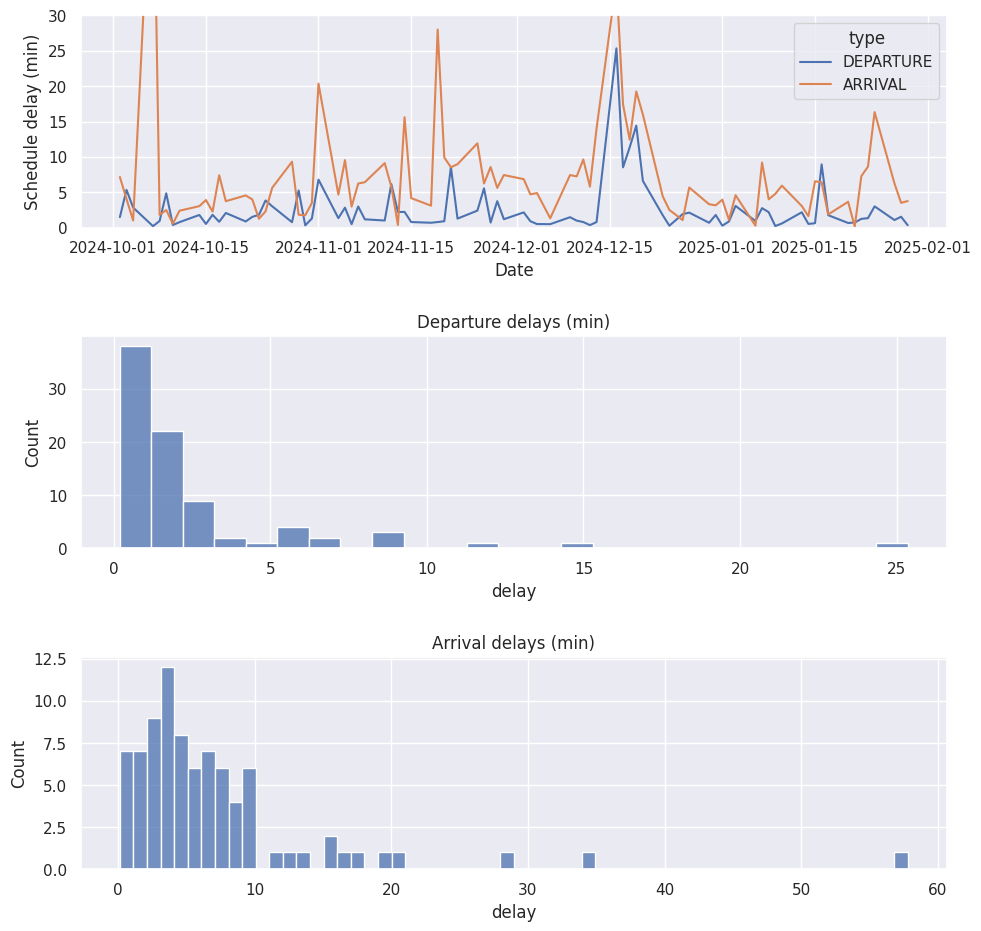

In [12]:
plot_differences(df=df_80)

In [13]:
print_summary(df=df_80)

Scheduled departure time: 07:04:00
Scheduled arrival time: 08:48:00
Delay stats:
shape: (5, 3)
┌───────────┬─────────────┬──────────────┐
│ statistic ┆ Delay (min) ┆ Arrival time │
│ ---       ┆ ---         ┆ ---          │
│ str       ┆ f64         ┆ time         │
╞═══════════╪═════════════╪══════════════╡
│ min       ┆ 0.15        ┆ 08:48:09     │
│ 50%       ┆ 4.883333    ┆ 08:52:53     │
│ 90%       ┆ 15.616667   ┆ 09:03:37     │
│ 95%       ┆ 19.25       ┆ 09:07:15     │
│ max       ┆ 57.783333   ┆ 09:45:47     │
└───────────┴─────────────┴──────────────┘


# Pasila -> Tampere

In [29]:
train_list_51 = await fetch_train_for_dates(
    train=51,
    dates=date_list,
    max_concurrent=5,
    sleep_after_sec=1.0,
)
df_51 = train_list_to_dataframe(
    train_list=train_list_51, departure="PSL", arrival="TPE"
)

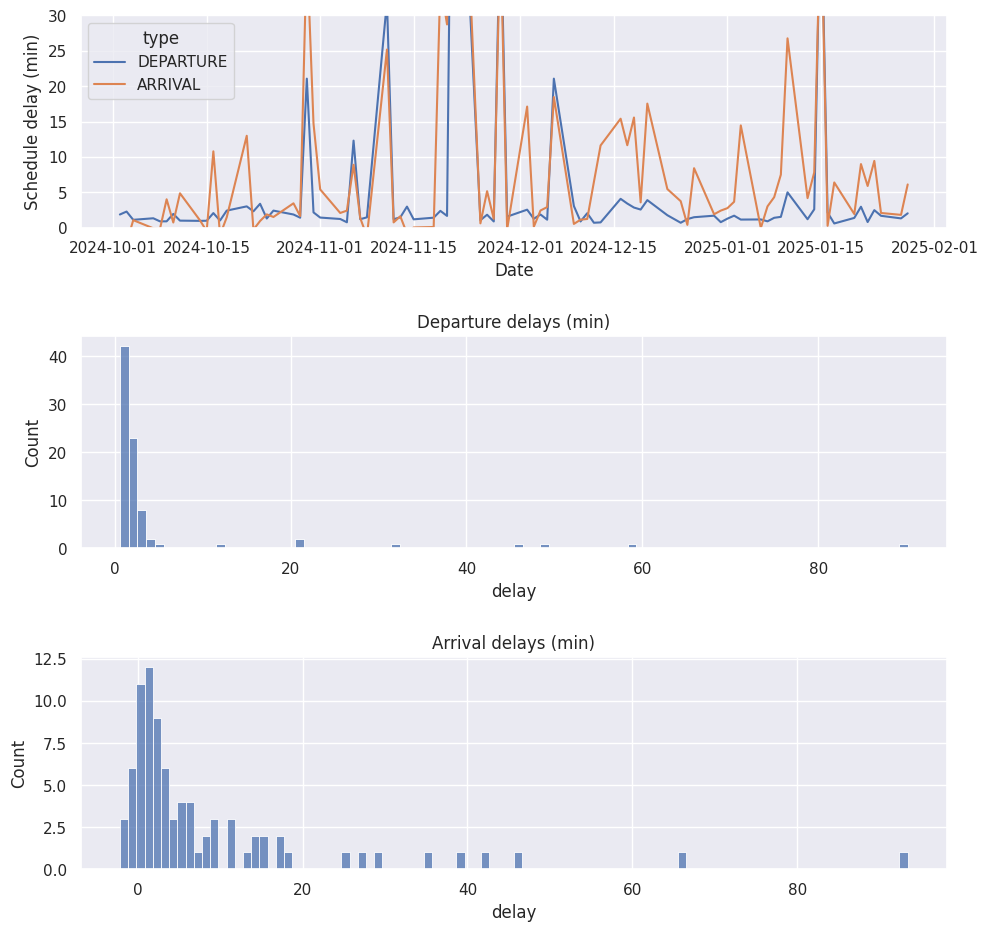

In [30]:
plot_differences(df=df_51)

In [31]:
print_summary(df=df_51)

Scheduled departure time: 16:30:00
Scheduled arrival time: 17:58:00
Delay stats:
shape: (5, 3)
┌───────────┬─────────────┬──────────────┐
│ statistic ┆ Delay (min) ┆ Arrival time │
│ ---       ┆ ---         ┆ ---          │
│ str       ┆ f64         ┆ time         │
╞═══════════╪═════════════╪══════════════╡
│ min       ┆ -2.166667   ┆ 17:55:50     │
│ 50%       ┆ 3.0         ┆ 18:01:00     │
│ 90%       ┆ 25.183333   ┆ 18:23:11     │
│ 95%       ┆ 39.566667   ┆ 18:37:34     │
│ max       ┆ 93.4        ┆ 19:31:24     │
└───────────┴─────────────┴──────────────┘


In [17]:
train_list_59 = await fetch_train_for_dates(
    train=59,
    dates=date_list,
    max_concurrent=5,
    sleep_after_sec=1.0,
)
df_59 = train_list_to_dataframe(
    train_list=train_list_59, departure="PSL", arrival="TPE"
)

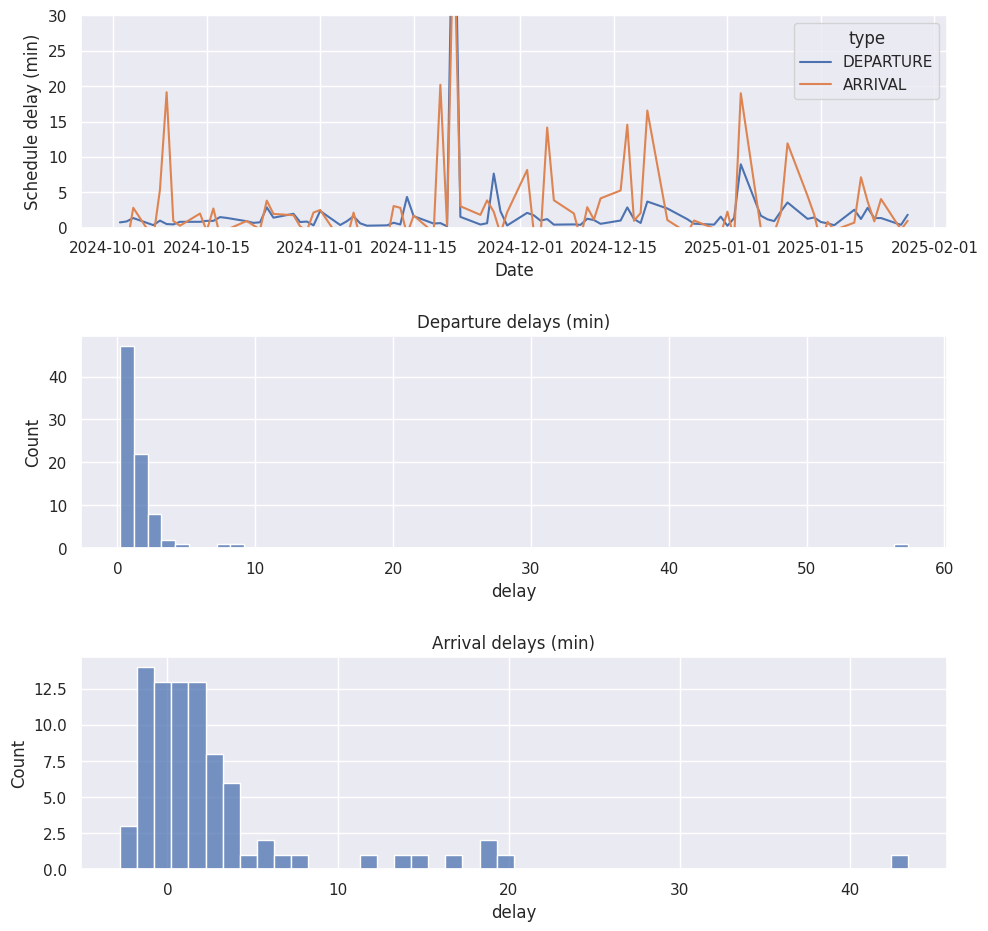

In [18]:
plot_differences(df=df_59)

In [19]:
print_summary(df=df_59)

Scheduled departure time: 16:46:00
Scheduled arrival time: 18:21:00
Delay stats:
shape: (5, 3)
┌───────────┬─────────────┬──────────────┐
│ statistic ┆ Delay (min) ┆ Arrival time │
│ ---       ┆ ---         ┆ ---          │
│ str       ┆ f64         ┆ time         │
╞═══════════╪═════════════╪══════════════╡
│ min       ┆ -2.783333   ┆ 18:18:13     │
│ 50%       ┆ 1.066667    ┆ 18:22:04     │
│ 90%       ┆ 8.15        ┆ 18:29:09     │
│ 95%       ┆ 16.55       ┆ 18:37:33     │
│ max       ┆ 43.366667   ┆ 19:04:22     │
└───────────┴─────────────┴──────────────┘


In [20]:
train_list_177 = await fetch_train_for_dates(
    train=177,
    dates=date_list,
    max_concurrent=5,
    sleep_after_sec=1.0,
)
df_177 = train_list_to_dataframe(
    train_list=train_list_177, departure="PSL", arrival="TPE"
)

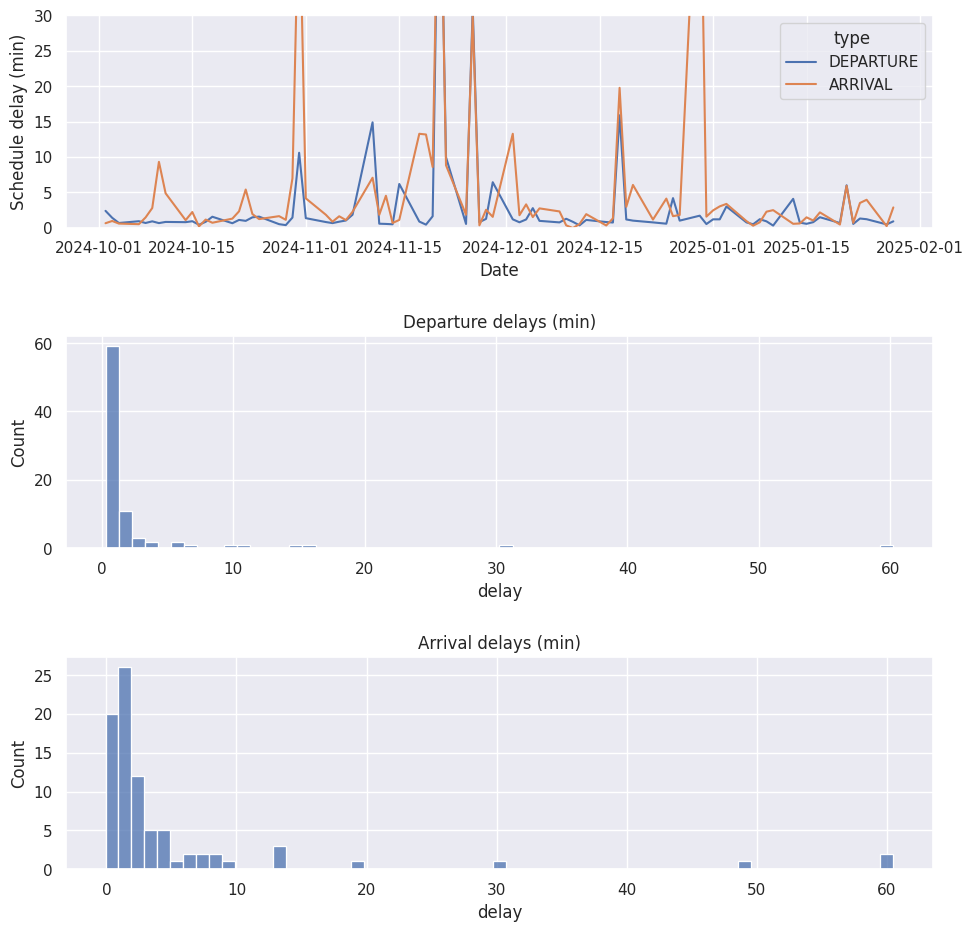

In [21]:
plot_differences(df=df_177)

In [22]:
print_summary(df=df_177)

Scheduled departure time: 17:09:00
Scheduled arrival time: 18:53:00
Delay stats:
shape: (5, 3)
┌───────────┬─────────────┬──────────────┐
│ statistic ┆ Delay (min) ┆ Arrival time │
│ ---       ┆ ---         ┆ ---          │
│ str       ┆ f64         ┆ time         │
╞═══════════╪═════════════╪══════════════╡
│ min       ┆ -0.066667   ┆ 18:52:56     │
│ 50%       ┆ 1.816667    ┆ 18:54:49     │
│ 90%       ┆ 9.3         ┆ 19:02:18     │
│ 95%       ┆ 19.766667   ┆ 19:12:46     │
│ max       ┆ 60.483333   ┆ 19:53:29     │
└───────────┴─────────────┴──────────────┘


In [23]:
train_list_49 = await fetch_train_for_dates(
    train=49,
    dates=date_list,
    max_concurrent=5,
    sleep_after_sec=1.0,
)
df_49 = train_list_to_dataframe(
    train_list=train_list_49, departure="PSL", arrival="TPE"
)

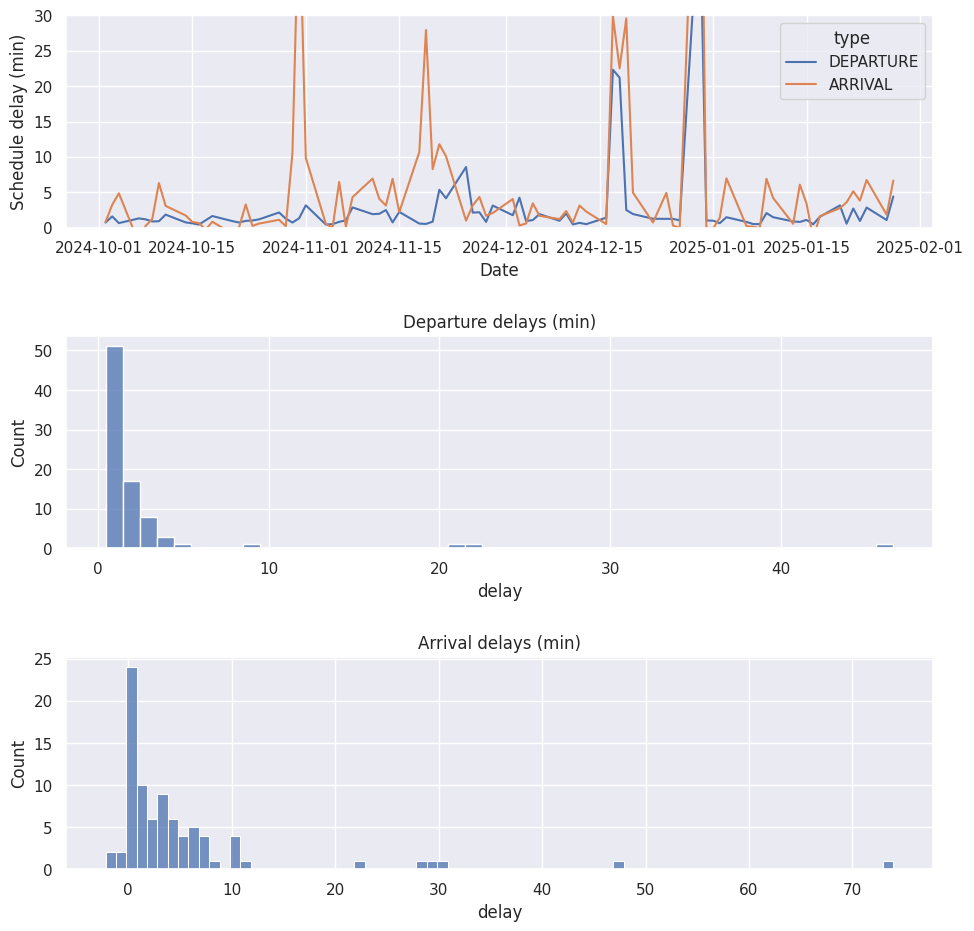

In [24]:
plot_differences(df=df_49)

In [25]:
print_summary(df=df_49)

Scheduled departure time: 17:30:00
Scheduled arrival time: 18:58:00
Delay stats:
shape: (5, 3)
┌───────────┬─────────────┬──────────────┐
│ statistic ┆ Delay (min) ┆ Arrival time │
│ ---       ┆ ---         ┆ ---          │
│ str       ┆ f64         ┆ time         │
╞═══════════╪═════════════╪══════════════╡
│ min       ┆ -2.2        ┆ 18:55:48     │
│ 50%       ┆ 2.333333    ┆ 19:00:20     │
│ 90%       ┆ 10.6        ┆ 19:08:36     │
│ 95%       ┆ 27.933333   ┆ 19:25:56     │
│ max       ┆ 73.95       ┆ 20:11:57     │
└───────────┴─────────────┴──────────────┘
